# PLONK in Code and Words

#### Authored by Jay Butera and Amir Taaki

Welcome on your journey to the black magicry of zk-snarks. Plonk, developed by Ariel Gabizon [in this paper](https://github.com/arielgabizon/plonk/blob/master/PLONK.pdf), is essentially the KZG polynomial commitment scheme where the polynomial is an arithmetized program and its inputs.

Therefore it is very useful and advisable to review the KZG polynomial commitment scheme first. [Read these notes](https://arnaucube.com/blog/kzg-commitments.html) for a brief overview of the entire protocol. For a more verbose review [read this next](https://dankradfeist.de/ethereum/2020/06/16/kate-polynomial-commitments.html).

This document is intended to be a comprehensive in-depth introduction to Plonk. There are links to necessary information to fill gaps in the explanation here. Many times you will need to read sections of the Plonk paper as referenced throughout this document.

Very little prior knowledge about snarks is assumed in this guide. If you do have no prior experience however, [From zero to bulletproofs](https://github.com/AdamISZ/from0k2bp/blob/master/from0k2bp.pdf) is a great introduction to basic cryptographic concepts like Pederson commitments (homomorphic encryption), commitments to vectors, and methods for reasoning about zero knowledge. It will be very useful to read the first 3 sections.

This guide also makes use of basic abstract algebra concepts like groups and fields, and of the [Sage](https://www.sagemath.org/) python math exension.

This is not intended to be a short overview to get a feeling for the technology. If you focus on this document alone and the supplementary resources referenced, with patience and time you can come to understand the entire protocol.

You can also ask questions in the [PLONK cafe](https://www.plonk.cafe/).

## Initial parameters

Remember that an algebraic field contains a multiplicative subgroup.

The order of the field, q, is a prime chosen so that the multiplicative group has a subgroup of order $2^{32}$, as well as all smaller powers of two. You will use these subgroups to encode the program in a polynomial later. 

In [1]:
q = 0x40000000000000000000000000000000224698fc0994a8dd8c46eb2100000001
K = GF(q)
P.<X> = K[]

In [2]:
#p = 0x1a0111ea397fe69a4b1ba7b6434bacd764774b84f38512bf6730d2a0f6b0f6241eabfffeb153ffffb9feffffffffaaab
#Kk = GF(p)
#ak = Kk(0x00)
#bk = Kk(0x04)
#E = EllipticCurve(Kk, (ak, bk))

# Generators which form the curve pairing
g1 = 0x17F1D3A73197D7942695638C4FA9AC0FC3688C4F9774B905A14E3A3F171BAC586C55E83FF97A1AEFFB3AF00ADB22C6BB
g2 = 0x08B3F481E3AAA0F1A09E30ED741D8AE4FCF5E095D5D00AF600DB18CB2C04B3EDD03CC744A2888AE40CAA232946C5E7E1

#G = E(g1, g2)
#E.set_order(0x73EDA753299D7D483339D80809A1D80553BDA402FFFE5BFEFFFFFFFF00000001 * 0x396C8C005555E1568C00AAAB0000AAAB)

## Arithmetization

Arithmetization is the process of compiling a program as a series of equations.

In [3]:
s = 1
x = 2
y = 3

if s:
    x * y
else:
    x + y

This can be expressed mathematically as $sxy + (1-s)(x + y)$. Notice how s, a boolean 0 or 1, will choose either $xy$ or $x + y$ depending on its value.

Read the [How PLONK works](https://vitalik.ca/general/2019/09/22/plonk.html) section in Vitalik's blog post for a soft introduction to arithmetization. Section 6 of the Plonk paper also describes the process.

Below is a simple "compiler" to transform a nested expression of additions and multiplications into the rows for plonk arithmetization. You can try plugging in different expressions.

In [4]:
# Generates a table from a parsed expr tree
def to_table(node):
    # Tuples of (a, b, c, q_l, q_r, q_o, q_m, q_c)
    table = []

    if type(t := node) == tuple:
        (op, a, b) = t
        # Recurse
        if ta := to_table(a):
            table += ta
        if tb := to_table(b):
            table += tb

        # Add top level
        if op == '+':
                a = evaluate(a)
                b = evaluate(b)
                table.append((a,b,a+b,1,1,-1,0,0))
        if op == '*':
                a = evaluate(a)
                b = evaluate(b)
                table.append((a,b,a*b,0,0,-1,1,0))

    return table

# Execute a program and return its value
def evaluate(node):
    if type(t := node) == tuple:
        (op, a, b) = t
        a = evaluate(a)
        b = evaluate(b)
        if op == '+': return a+b
        if op == '*': return a*b
    return node

# Generate the q and permutation polynomials in the preprocess step
def preprocess(table):
    a =  [row[0] for row in table]
    b =  [row[1] for row in table]
    c =  [row[2] for row in table]
    ql = [row[3] for row in table]
    qr = [row[4] for row in table]
    qo = [row[5] for row in table]
    qm = [row[6] for row in table]
    qc = [row[7] for row in table]
    
    return (a,b,c,ql,qr,qo,qm,qc)

In [5]:
# Hidden values
s = 1
x = 4
y = 6

#program = ('+', ('*', 5, 6), 2)
program = \
    ('+',
      ('*', s ,('*', x, y)),
      ('*', ('+', 1, -s), ('+', x, y)))


table = to_table(program)
(a,b,c,ql,qr,qo,qm,qc) = preprocess(table)
(a,b,c,ql,qr,qo,qm,qc)

([4, 1, 1, 4, 0, 24],
 [6, 24, -1, 6, 10, 0],
 [24, 24, 0, 10, 0, 24],
 [0, 0, 1, 1, 0, 1],
 [0, 0, 1, 1, 0, 1],
 [-1, -1, -1, -1, -1, -1],
 [1, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0])

The circuit needs to be exactly a power of two in length. Find the smallest power of two greater than or equal to the length of the circuit and append zero-padding to make the circuit that length.

n being a power of 2 has to do with the multiplicative subgroups mentioned earlier. To encode the circuit as a polynomial you will make use of the subgroup of size n. More on this in "Deriving the Roots of Unity" below.

In [6]:
def find_min_power_of_2(x):
    n = 1
    while 2^n < x:
        n += 1
    return 2^n

n = find_min_power_of_2(len(a))
n

8

In [7]:
len_diff = n - len(a)

for _ in range(len_diff):
    a.append(0)
    b.append(0)
    c.append(0)
    ql.append(0)
    qr.append(0)
    qm.append(0)
    qo.append(0)
    qc.append(0)

## Trusted Setup

As described in KZG, Plonk requires a random seed x, which cannot be known by either the verifier or the prover. The method for generating the "toxic waste" x is outside the scope of plonk. For discussion purposes consider a trusted third party which generates x, constructs the structured reference string (SRS) from x and then discards x so that no one knows it.

The SRS is a list of powers of x multiplied by the two generator points

$ x^0g_1, x^1g_1, ..., x^{n+5}g_1 $

$ x^0g_2, x^1g_2, ..., x^{n+5}g_2 $

In [8]:
x = K.random_element()
xs_1 = [x^i*g1 for i in range(n+5)]
xs_2 = [x^i*g2 for i in range(n+5)]

## Deriving The Roots of Unity

The field also has a prime order, denoted $GF(q)$, which means the order of the multiplicative group is q-1 [from wikipedia](https://en.wikipedia.org/wiki/Finite_field#Multiplicative_structure).

To derive the nth roots of unity where n is $2^{32}$, take the generator of the multiplicative group of $GF(q)$, call it g, and raise g to the power $(q-1)/2^{32}$. Remember q-1 is the order of the group which g generates. So $g^{q-1} = 1$. To see what happens when you divide the order of a subgroup by the order of the group, first we should simplify terms; $m=q-1, k=2^{32}$.

Consider the order of the group generated by $|<g^{m/k}>|$

When multiplied by k, $g^{m/k^k} = g^m = 1$. Therefore the order of the generated group must be k since the generator applied k times is 1. This is how we derive the generator for the $2^{32}$ roots of unity, called $\omega$. Raise the generator g to the order $g^{m/k}$.

You will see asserts sprinkled throughout the code in this document. These are not necessary for the proof construction but should help you as the reader to understand properties of the constructions.

In [9]:
# Get the generator for the nth roots of unity
def omega(n):
    g = K.multiplicative_generator()
    t = (q-1)/n
    return g^t

omega = omega(n)
print(omega)

assert omega^n == 1
for i in range(1,n):
    assert omega^i != 1

26389178552394651245246837090492411671330744266237564696174733440959711379620


## Indexing Polynomials

In a computer we index into arrays with an offset i. In math, polynomials are used like arrays. To use a polynomial like an array, you could encode the polynomial p, so that $p(i) = v[i]$.

PLONK uses a polynomial called $L_i(x)$ which is defined so that $L_i(w^i) = 1$, and 0 for all other roots of unity. See the definition of L at the beginning of section 5 in the PLONK paper.

## Encoding lists as Polynomials

Polynomials are the mathematical version of a list. In Plonk, values of the list are indexed at powers of $\omega$.

The whole point of a snark is to utilize the [Schwartz-Zippel](https://en.wikipedia.org/wiki/Schwartz%E2%80%93Zippel_lemma) property of polynomials to make very convincing arguments about a large range of values without actually inspecting them all. At the end there will be a single polynomial which aggregates all the smaller polynomials of important information for the proof.

Now you start encoding polynomials of the circuit. Polynomial interpolation is used for this.

In [10]:
Ql_X = P.lagrange_polynomial((omega^i, ql_i) for i, ql_i in enumerate(ql))
Qr_X = P.lagrange_polynomial((omega^i, qr_i) for i, qr_i in enumerate(qr))
Qo_X = P.lagrange_polynomial((omega^i, qo_i) for i, qo_i in enumerate(qo))
Qm_X = P.lagrange_polynomial((omega^i, qm_i) for i, qm_i in enumerate(qm))
Qc_X = P.lagrange_polynomial((omega^i, qc_i) for i, qc_i in enumerate(qc))

## Copy Constraints

The above polynomial encoding of the circuit expresses a constraint on each line, but doesn't connect the variables which are the same between lines.

To understand how copy constraints bridge this gap, start by reading the "Copy Constraints" section on [Vitalik's Plonk article](https://vitalik.ca/general/2019/09/22/plonk.html). 

Once you understand how the accumulator pairs enforce the constraint, read up to the "Argument Specification" section of the article on [Halo permutations](https://zcash.github.io/halo2/design/proving-system/permutation.html) to get a better idea of how to encode the polynomial. The last sections are specific to Halo, not Plonk.

Read section 5 of the Plonk paper, which will reinforce your understanding and familiarize you with the notation used for Plonk. More information about $\sigma^*$ in section 8.1 of the paper.

### The Permutation Algorithm

The permutation construction algorithm is simple. Concatenate the witness arrays $w = a+b+c$, and iterate over $w$, for each element searching the following elements for the first matching value, and swap the indexes if found.

In [11]:
witness = a + b + c

perm = [i for i,_ in enumerate(witness)]
for i in range(len(witness)):
    for j in range(i+1, len(witness)):
        if witness[j] == witness[i]:
            #print('found match', witness[j], "at", j, "and", i)
            
            # Swap
            tmp = perm[i]
            perm[i] = perm[j]
            perm[j] = tmp
            break

print(perm)

[3, 2, 1, 0, 6, 9, 7, 13, 11, 16, 10, 8, 19, 14, 15, 18, 17, 21, 20, 12, 22, 5, 23, 4]


### Construct the $\sigma^*$ Permutation

The $\sigma^*$ is a permutation over the three witness polynomials a,b,c. Read section 8.1 to understand it's construction. It uses the roots of unity to index the permutation of size $3n$. Because there are only n roots of unity, and $\omega^i = \omega^{n+i}$, there needs to be a way to distinguish these elements.

Plonk uses [quadratic non-residues](https://en.wikipedia.org/wiki/Quadratic_residue) which form different cosets of $H$, the roots of unity, to do this. A quadratic residue mod q is a number a which can be expressed as a quadratic of another number in the group $a = b^2$. 

We find two quadratic non-residues, $k_1, k_2$, using an extension of the [Legendre symbol](https://en.wikipedia.org/wiki/Legendre_symbol). We must then make sure they don't form the same coset, $k_1H = k_2H$. We can do this by simply checking one element from each, since none should overlap.

Finally, encode $\sigma^*$ in three polynomials indexed by the nth roots of unity.

In [12]:
def rand_nonquadratic_residue():
    k = K.random_element()
    while kronecker(k, q) != -1:
        k = K.random_element()
        
    return k

k1 = rand_nonquadratic_residue()
k2 = rand_nonquadratic_residue()

#k1 = 3743749184259895985410397423611337181690386628492621551196449208577957147100
#k2 = 19930379861637324095376072787537755553917267237357339837232655761235933545310

assert k1 != k2
assert k1*omega != k2*omega

In [13]:
indices = ([omega^i for i in range(n)]
            + [k1 * omega^i for i in range(n)]
            + [k2 * omega^i for i in range(n)])

sigma_star = [indices[perm[i]] for i in range(3*n)]


# sigmastar permutation as three polynomials
sig1_X = P.lagrange_polynomial((omega^i, sigma_star[i]) for i in range(n))
sig2_X = P.lagrange_polynomial((omega^i, sigma_star[n+i]) for i in range(n))
sig3_X = P.lagrange_polynomial((omega^i, sigma_star[2*n+i]) for i in range(n))

Now with everything in the setup phase done, you can commit to the witness polynomials a,b,c. This is round 1 in plonk.

In [14]:
# Prover generates 6 random scalars in GF(q)
[b1,b2,b3,b4,b5,b6,b7,b8,b9] = [1 for _ in range(9)]#[K.random_element() for _ in range(9)]

## Vanishing Polynomial

$Z_H$ is a polynomial which evaluates to 0 at the roots of unity H. Values at other points are non-zero. A straightforward construction of $Z_H$ is all the factors at the roots: $Z_H(X) = (X-\omega^0)(X-\omega^1)\cdots(X-\omega^n)$.

But the same polynomial can be expressed as $Z_H(X) = X^n-1$ since it is a theorem that $X^n = 1$ for all elements $X$ in a group of order n, where in this case n is the order of the subgroup nth roots of unity.

In [15]:
Z_H = X^n - 1

for i in range(n):
    assert Z_H(omega^i) == 0

## Round 1

Construct the witness polynomials and commit to them at the point of the trusted setup parameter.

In [16]:
a_X = (b1*X+b2)*Z_H + P.lagrange_polynomial((omega^i, a[i]) for i in range(n))
b_X = (b3*X+b4)*Z_H + P.lagrange_polynomial((omega^i, b[i]) for i in range(n))
c_X = (b5*X+b6)*Z_H + P.lagrange_polynomial((omega^i, c[i]) for i in range(n))

for i in range(n):
    assert a[i] == a_X(omega^i)

You can see the polynomial looks random due to Z_H and the blinding factors. The witness values are embedded into the randomness.

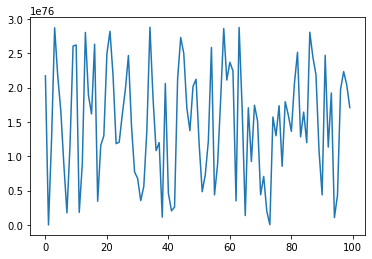

In [17]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot([i for i in range(100)], [a_X(i) for i in range(100)])

Commit to the witness polynomials a,b,c as in the KZG commitment scheme. Notice from the scheme that $C = [p(x)]_1 = \sum_{i=0}^{deg(p(x))} [\tau^i] \cdot p_i$.

In [35]:
# Remove initial zeros which sage adds in a polynomial coefficient list
'''
def unpadded(l):
    while l[0] == 0:
        l.remove(0)
    return l
'''

# Commit to a polynomial at the trusted setup value x, using generator g1
def commit_1(poly):
    Cp_1 = 0
    for i, p_i in enumerate(poly.list()):
        Cp_1 += p_i * xs_1[i]
    return Cp_1

Ca_1 = commit_1(a_X)
Cb_1 = commit_1(b_X)
Cc_1 = commit_1(c_X)
    
(Ca_1, Cb_1, Cc_1)

(21195042919395041520554801212504920238785026299677899070131909532180832513618,
 21879264387841397675097223167214848705139948157417251091382754305222066796923,
 25643018008935449037616189235737095762142479713558170312971663529180600288136)

## Round 2

Compute Fiat-Shamir challenges $\beta, \gamma$. These would be randomly chosen values provided by the verifier in an interactive protocol, but the Fiat-Shamir heuristic ensures the prover can't choose favorable values which would help them falsify the proof.

Remember that commitments in the transcript (Ca_1, ...) are points in the group. When converting to strings they may be different lengths. Cryptographers like to be sure there is no room for ambiguity, so it is common practice to insert a delimiter, |, between points. This distinguishes concatenating numbers like 123, 456 from numbers 12, 3456.

In [19]:
transcript = [str(Ca_1), str(Cb_1), str(Cc_1)]
beta = hash('|'.join(transcript) + '0')
gamma = hash('|'.join(transcript) + '1')

beta = 13221126506858500342419753147213623108357776356575276450266108156614729463975
gamma = 21010720231774318035415855699715358516647461224162570325176355814698576594896

Go back to [Vitalik's article](https://vitalik.ca/general/2019/09/22/plonk.html) and read the section on copy constraints. He explains how the "accumulator" is used to aggregate values of a polynomial, and how you can be sure that two accumulated sums with different X values are the same if the Y values match up to the permutation of X.

Read section 5, "Polynomial protocols for identifying permutations", to complete the connection to how they are used in Plonk.

In [20]:
accumulator_points = [(1, 1)]

for i in range(n - 1):
    x = omega^(i + 1)
    y = 1
    for j in range(i + 1):
        y *= witness[j] + beta * omega^j + gamma
        y *= witness[n + j] + beta * k1 * omega^j + gamma
        y *= witness[2 * n + j] + beta * k2 * omega^j + gamma
        y /= witness[j] + sigma_star[j] * beta + gamma
        y /= witness[n + j] + sigma_star[n + j] * beta + gamma
        y /= witness[2 * n + j] + sigma_star[2 * n + j] * beta + gamma
    accumulator_points.append((x, y))
    
accumulator_points

[(1, 1),
 (26389178552394651245246837090492411671330744266237564696174733440959711379620,
  20543015394467538625576195086386901834977836897428997947665064469809389700872),
 (24682508875525884897641270952488416149830453149035712389703207095981135804695,
  8879907200039609801921570109736307375871783182857493557815176428252650197287),
 (4855188899445002300170730717563617051094175372704778513906105166874447905568,
  19920378110740247537525447736648654676038359511682832954947139220104543002223),
 (28948022309329048855892746252171976963363056481941647379679742748393362948096,
  15506378787423493375346494831772783612358907037417197382968668559543297095103),
 (2558843756934397610645909161679565292032312215704082683505009307433651568477,
  2217374552352269759590410770092470831092570465515451149230845918429643914370),
 (4265513433803163958251475299683560813532603332905934989976535652412227143402,
  7196449923070103033913205073277330656065769001570198713905771462834851146683),
 (24092833409884046

As an interesting aside, although the accumulator is encoding all the values before it and the next, both the x and y values (roots of unity and accumulator points) are not just progressively bigger and bigger.

In fact the accumulator reaches a value greater than $q$, the order of the group, quickly. But because this is a group, subtracting a value will still return the previous iteration.

Finally commit to $Z$, the encoded accumulator, aka permutation polynomial.

In [21]:
# Blinding factor + 1 at omega + accumulator points at each index of witness values
z_X = (b7*X^2+b8*X+b9) * Z_H \
    + P.lagrange_polynomial(accumulator_points)

assert z_X(1) == 1

In [22]:
Cz_1 = commit_1(z_X)
Cz_1

12434460167838954159624346180705212326874188265009397806089842418822842817504

## Round 3

In round 3 the entire circuit - each row, the copy constraints, and the base case $\omega = 1$ are encoded in a single polynomial which is then split into three polynomials of degree < n, and each are commited to.

In [23]:
# Compute the new challenge
alpha = hash(str(Cz_1))
alpha

2437447427209435554

In [24]:
circuit_X = (a_X*b_X*Qm_X + a_X*Ql_X + b_X*Qr_X + c_X*Qo_X + Qc_X)

zf_X = ((a_X + beta*X + gamma)
        * (b_X + beta*k1*X + gamma)
        * (c_X + beta*k2*X + gamma)
        * z_X)

gz_X = ((a_X + beta * sig1_X + gamma)
        * (b_X + beta * sig2_X + gamma)
        * (c_X + beta * sig3_X + gamma)
        * z_X(X * omega))

l1_X = P.lagrange_polynomial([(1, z_X(1)-1)] + [(omega^i, 0) for i in range(1,n)])

for i in range(n):
    assert zf_X(omega^i) == gz_X(omega^i)

Notice zf_X - gz_X is the check b of step 5 in the permutation protocol in section 5; 

$Z(a)f(a) = g(a)Z(a \cdot g)$

L1z is check a;

$L_1(a)(Z(a) - 1) = 0$

In the following polynomial t, all three constraint checks are combined. Dividing by 0 at the roots of unity (Z_H) ensures that the constraints are also 0 or else the function is undefined.

In [25]:
t_X, rem_X = (circuit_X + (zf_X - gz_X) * alpha + l1_X * alpha^2).quo_rem(Z_H)

assert rem_X == 0
t_X

27112917161463273578172170506036799771449424879585859822484144488627959941960*X^29 + 14717910879807124457683241763262247544859915350741910358842628710330621788677*X^28 + 787946256658544353100999925225585477823442602339044158266343781306505059275*X^27 + 24301808986619980925861046222835411275252020611997250069379796752447385314283*X^26 + 25402340306991744556474406296152952518478635658571008533209776766168092380932*X^25 + 20091507465728143675951990337247506416448218234501539696234789677709256396033*X^24 + 18085867687526526638259053517220916511575688796871774657997971696805616880153*X^23 + 18809352677897747560996177202636434481969097954832123566789292914175411027827*X^22 + 11731317026039578143221150586320766493583182578140092827590363325978969299783*X^21 + 25137885427326600336922842795370924241336537550675407560474102078660437216481*X^20 + 1200744605905360019796700146373408832442925146436223806453287375314811333241*X^19 + 15641361424956838115984983830785428224244879850853977701819596292776

Before commiting to t, notice that t has a much larger degree than n (the length of polynomials a,b,c). This is because many polynomials were multiplied together to get t (like $a \cdot b \cdot q_m$).

Remember in the the trusted setup, n+5 different exponentiations of the toxic waste value x are produced. Those values are used to commit to polynomials. Which means a commited polynomial can't be greater than degree n+5.

To fix t, split it into 3 sub-polynomials and commit to each.

In [26]:
coefs = t_X.list()
t_lo_X  = sum([coefs[i] * X^i for i in range(n+5)])
t_mid_X = sum([coefs[i+(n+5)] * X^i for i in range(n+5)])
t_hi_X  = sum([coefs[i+(2*n+10)] * X^i for i in range(len(coefs) - (2*n+10))])

print(len(t_lo_X.list()))
print(len(t_mid_X.list()))
print(len(t_hi_X.list()))

13
13
4


In [27]:
Ct_lo_1  = commit_1(t_lo_X)
Ct_mid_1 = commit_1(t_mid_X)
Ct_hi_1  = commit_1(t_hi_X)

## Round 4

In round 3 the final circuit constraint polynomial was constructed. All information about the faithful execution of the circuit is encoded in polynomial $t$.

In round 4 you will create an evaluation challenge $\zeta=H(transcript)$, and use it to evaluate polynomials $a,b,c,s_{\sigma1},s_{\sigma2},s_{\sigma3}$ at $\zeta$. Also evaluate polynomial $z=z(\zeta \omega)$.

$\zeta$ is the random point at which you are evaluating the polynomials to prove you have knowledge of them. This is critical to the intuitional understanding of the snark. The input to the polynomial, z, is not the hidden inputs to the circuit. It is a random value "chosen" by the verifier, for which the prover must evaluate the polynomial at that point, and the verifier can see that the evaluation, y, is indeed equal to p(z). See the [Schwartz-Zippel Lemma](https://en.wikipedia.org/wiki/Schwartz%E2%80%93Zippel_lemma) to understand why evaluating a polynomial at an arbitrary point can be a convincing argument of total knowledge of that (commited to) polynomial.

In the KZG commitment scheme, you are proving $p(z) = y$. In Plonk, z here is the random point $\zeta$. But of course what you really want to prove is that the circuit evaluated on secret inputs a,b produce hidden outputs c. Therefore the KZG polynomial p that you are proving an evaluation on in Plonk encodes not just the circuit but also the input and output relations themselves. The KZG evaluation proof $p(\zeta) = y$ is instead using the Schwartz-Zippel lemma to say "all these polynomials actually exists and the prover has knowledge of them". And the polynomials encode all the inputs, outputs, and execution of the circuit.

In [28]:
zeta = hash('|'.join([str(Ct_lo_1), str(Ct_mid_1), str(Ct_hi_1)]))

In [29]:
ea = a_X(zeta)
eb = b_X(zeta)
ec = c_X(zeta)
ezw = z_X(zeta * omega)
esig1 = sig1_X(zeta)
esig2 = sig2_X(zeta)

## Round 5

Now to finish the proof of knowledge started in round 4, you construct a polynomial, r, which serves as the numerator $p(x) - y$ in the proof polynomial $q(x)$ from KZG. Polynomial r is not actually sent to the verifier. The verifier reconstructs it from the evaluations at $\delta$ and commitments.

Read the "reducing the number of field elements" paragraph in section 4.2 of the plonk paper. It explains a way to reduce the number of field elements required to communicate in a polynomial multiplication proof.

This technique is used on every term of polynomial r. Notice there is only one polynomial "open" to X in every term of r. The others are evaluated at $\delta$.

In [30]:
v = hash('|'.join([str(ea), str(eb), str(ec), str(ezw), str(esig1), str(esig2)]))

In [31]:
r_X = ((ea*eb*Qm_X + ea*Ql_X + eb*Qr_X + ec*Qo_X + Qc_X)
       + (alpha * ((ea + beta*zeta + gamma)
                * (eb + beta*k1*zeta + gamma)
                * (ec + beta*k2*zeta + gamma) * z_X
       - (ea + beta*esig1 + gamma)
          * (eb + beta*esig2 + gamma)
          * (ec + beta*sig3_X + gamma) * ezw))
       + alpha^2 * l1_X(zeta)
       - Z_H(zeta) * (t_lo_X + zeta^(n+5) * t_mid_X + zeta^(2*n+10) * t_hi_X))

assert r_X(zeta) == 0

In [32]:
Wz_X, rem = (r_X
        + v*(a_X - ea)
        + v^2*(b_X - eb)
        + v^3*(c_X - ec)
        + v^4*(sig1_X - esig1)
        + v^5*(sig2_X - esig2)).quo_rem(X - zeta)

assert rem == 0

Wzw_X, rem = (z_X - ezw).quo_rem(X - zeta * omega)

assert rem == 0

Wz_X(zeta)
Wzw_X(zeta * omega)

23445379263584937698600239711170545210013107116918709049004589597053346635705

In [33]:
C_wz_1 = commit_1(Wz_X)
C_wzw_1 = commit_1(Wzw_X)

# End of Proof

Now for how to validate the proof

0. Compute some commitments necessary in the reconstruction

In [36]:
Cqm_1 = commit_1(Qm_X)
Cql_1 = commit_1(Ql_X)
Cqr_1 = commit_1(Qr_X)
Cqo_1 = commit_1(Qo_X)
Cqc_1 = commit_1(Qc_X)
Csig_1 = commit_1(sig1_X)
Csig_2 = commit_1(sig2_X)
Csig_3 = commit_1(sig3_X)

1. Check that all the commitments are points in the group. Since it is a property of groups that all elements raised to the order of the group is one, the check is simply that.

In [37]:
s = q-1
assert Ca_1^s == 1
assert Cb_1^s == 1
assert Cc_1^s == 1
assert Cz_1^s == 1
assert Ct_lo_1^s == 1
assert Ct_mid_1^s == 1
assert Ct_hi_1^s == 1
assert C_wz_1^s == 1
assert C_wzw_1^s == 1

2. Check the evaluation points are in the field $GF(p)$.

In [38]:
#TODO

3. Check public inputs are in the field, but this guide left out public inputs for brevity.

4. Compute the challenges in the same way as the prover

In [39]:
alpha = hash(str(Cz_1))
transcript = [str(Ca_1), str(Cb_1), str(Cc_1)]
beta = hash('|'.join(transcript) + '0')
gamma = hash('|'.join(transcript) + '1')
zeta = hash('|'.join([str(Ct_lo_1), str(Ct_mid_1), str(Ct_hi_1)]))
v = hash('|'.join([str(ea), str(eb), str(ec), str(ezw), str(esig1), str(esig2)]))
u = hash('|'.join([str(C_wz_1), str(C_wzw_1)]))

5. Evaluate the zero and first lagrange basis polynomials at zeta. While you can compute el1z by computing the lagrange basis polynomial and then evaluating it at zeta, the paper uses a math trick.

In [40]:
ezz = zeta^n - 1
el1z = (omega * (zeta^n - 1)) / (n * (zeta - omega))

6. 

In [41]:
r0 = el1z * alpha^2 - alpha * (ea + beta*esig1 + gamma) * (eb + beta*esig2 + gamma) * (ec + gamma) * ezw
#rp = r - r0

Fundamentally you are checking that the commitments to the final polynomial $[W_{\zeta}]_1, [W_{\zeta\omega}]_1$ are what they claim to be, which you can see the definitions of the polynomials in round 5 in the paper. To check that, you are reconstructing the definition using the provided evaluations and commitments to component polynomials of the circuit.

The paper makes use of three polynomials in the construction, $[D]_1, [F]_1, [E]_1$ (steps 9, 10 and 11 in the paper). Polynomial D is a reconstruction of polynomial r from round 5. The rest of F and E reconstruct the other openings in $W_\zeta$.

For instance $[F]_1$ contains $v \cdot [a]_1$ and $[E]_1$ contains $v \cdot e_a$. When subtracted as in the pairing formula in the final step, it makes $v(a-e_a)$ as in the definition of $W_\zeta$.

The reason F and E polynomials are split in the construction is because F contains pre-commited values from the prover, while E contains the evaluations at zeta, which all need to be multiplied by $[1]_1$ in order to subtract from F.

E also contains the term $u \cdot e_{\zeta_{\omega}}$ which corresponds to the term $u \cdot [W_{\zeta\omega}]_1$ in the left pairing formula of the final step.

In [43]:
CD_1 = ((ea*eb*Cqm_1 + ea*Cql_1 + eb*Cqr_1 + ec*Cqo_1 + Cqc_1)
     + (alpha * (ea + beta*zeta + gamma) * (eb + beta*k1*zeta + gamma) * (ec + beta*k2*zeta + gamma) + el1z*alpha^2 + u) * Cz_1
     - (ea + beta*esig1 + gamma)*(eb + beta*esig2 + gamma)*alpha*beta*ezw*Csig_3
     - ezz * (Ct_lo_1 + zeta^n*Ct_mid_1 + zeta^(2*n)*Ct_hi_1))

CF_1 = CD_1 + v*Ca_1 + v^2*Cb_1 + v^3*Cc_1 + v^4*Csig_1 + v^5*Csig_2
CE_1 = -r0 + v*ea + v^2*eb + v^3*ec + v^4*esig1 + v^5*esig2 + u*ezw


Now to see that final step, which checks the construction of W polynomials were made correctly. Expressed $(W_{\zeta} + u \cdot W_{\zeta\omega}) * x = \zeta \cdot W_{\zeta} + u\zeta\omega \cdot W_{\zeta\omega} + F - E$

In [44]:
# TODO elliptic cure pairing check